In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models
from torch.utils.data import Subset, DataLoader, random_split
from torchcp.classification.scores import THR, APS, SAPS, RAPS
import torch.nn as nn
from tqdm import tqdm
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_classes = 10
batch_size = 128
alphas = [0.99, 0.90, 0.75, 0.5, 0.25, 0.1, 0.01]
score_functions = ["THR", "SAPS", "RAPS", "APS"]
transform_test_with_channel_check = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])    
# Load FashionMNIST dataset
fashion_mnist_test_dataset = datasets.FashionMNIST(root='/shareddata', train=False, download=True, transform=transform_test_with_channel_check)

# Split the dataset into calibration (cal) and test sets
total_test_size = len(fashion_mnist_test_dataset)
cal_size = total_test_size // 2
test_size = total_test_size - cal_size
cal_indices, test_indices = torch.utils.data.random_split(range(total_test_size), [cal_size, test_size])
cal_dataset = Subset(fashion_mnist_test_dataset, cal_indices)
test_dataset = Subset(fashion_mnist_test_dataset, test_indices)

# Create DataLoader for calibration and test sets
cal_dataloader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.eval()
model.to(device)

# Dictionary to store results}
results_dict = {score_func: {predictor_name: {'coverage_rates': [], 'average_sizes': []} for predictor_name in ["SplitPredictor", "ClusterPredictor", "ClassWisePredictor"]} for score_func in score_functions}

# Process different score functions and alphas
for score_func in score_functions:
    for alpha in tqdm(alphas, desc=f'Processing alphas for {score_func}', unit='alpha'):
        # Define the score function
        if score_func == "THR":
            score_function = THR()
        elif score_func == "APS":
            score_function = APS()
        elif score_func == "SAPS":
            score_function = SAPS(0.5)
        elif score_func == "RAPS":
            score_function = RAPS(0.5)
        else:
            raise Exception("score_func error")

        # Process different predictors
        for predictor_name in ["SplitPredictor", "ClusterPredictor", "ClassWisePredictor"]:
            # Define the predictor
            if predictor_name == "SplitPredictor":
                predictor = SplitPredictor(score_function, model)
            elif predictor_name == "ClusterPredictor":
                predictor = ClusterPredictor(score_function, model)
            elif predictor_name == "ClassWisePredictor":
                predictor = ClassWisePredictor(score_function, model)
            else:
                raise Exception("predictor error")

            # Calibrate and evaluate the predictor
            predictor.calibrate(cal_dataloader, alpha)
            result = predictor.evaluate(test_dataloader)

            # Extract and store results
            coverage_rate = result['Coverage_rate']
            average_size = result['Average_size']

            results_dict[score_func][predictor_name]['coverage_rates'].append(coverage_rate)
            results_dict[score_func][predictor_name]['average_sizes'].append(average_size)

print("results_dict = ", results_dict)

Processing alphas for APS: 100%|██████████| 7/7 [00:47<00:00,  6.77s/alpha]

results_dict =  {'THR': {'SplitPredictor': {'coverage_rates': [0.0088, 0.096, 0.2406, 0.486, 0.7384, 0.8956, 0.9886], 'average_sizes': [0.2516, 1.0634, 2.0436, 3.7324, 6.6062, 8.6168, 9.9114]}, 'ClusterPredictor': {'coverage_rates': [0.0088, 0.0952, 0.2402, 0.4844, 0.7384, 0.8956, 0.99], 'average_sizes': [0.251, 1.0612, 2.0406, 3.7188, 6.606, 8.6164, 9.9216]}, 'ClassWisePredictor': {'coverage_rates': [0.011, 0.1102, 0.2568, 0.5086, 0.7468, 0.8936, 0.9874], 'average_sizes': [0.4268, 1.569, 2.6592, 4.2746, 5.9796, 7.273, 8.7568]}}, 'SAPS': {'SplitPredictor': {'coverage_rates': [0.0094, 0.1018, 0.2404, 0.4772, 0.7374, 0.9008, 0.9874], 'average_sizes': [0.129, 1.2032, 1.9248, 3.6942, 6.507, 8.7384, 9.846]}, 'ClusterPredictor': {'coverage_rates': [0.0104, 0.0998, 0.2414, 0.4876, 0.7334, 0.899, 0.9904], 'average_sizes': [0.167, 1.2042, 1.93, 3.7524, 6.4822, 8.7238, 9.8746]}, 'ClassWisePredictor': {'coverage_rates': [0.0136, 0.1038, 0.2478, 0.501, 0.7578, 0.8974, 0.9902], 'average_sizes': [0.

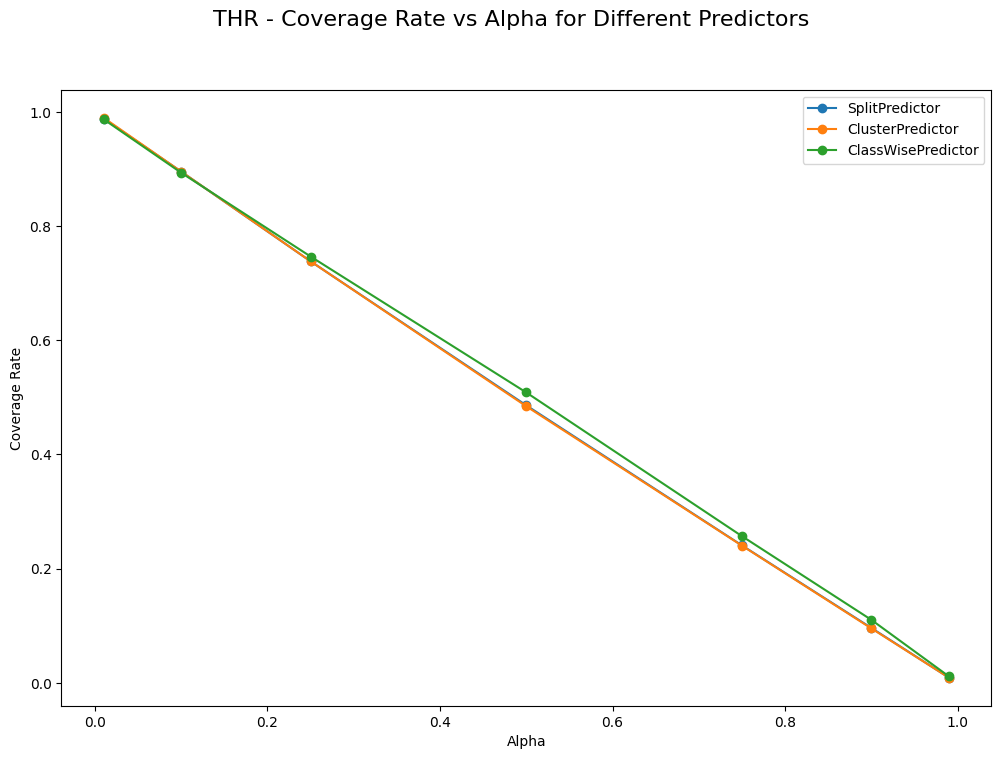

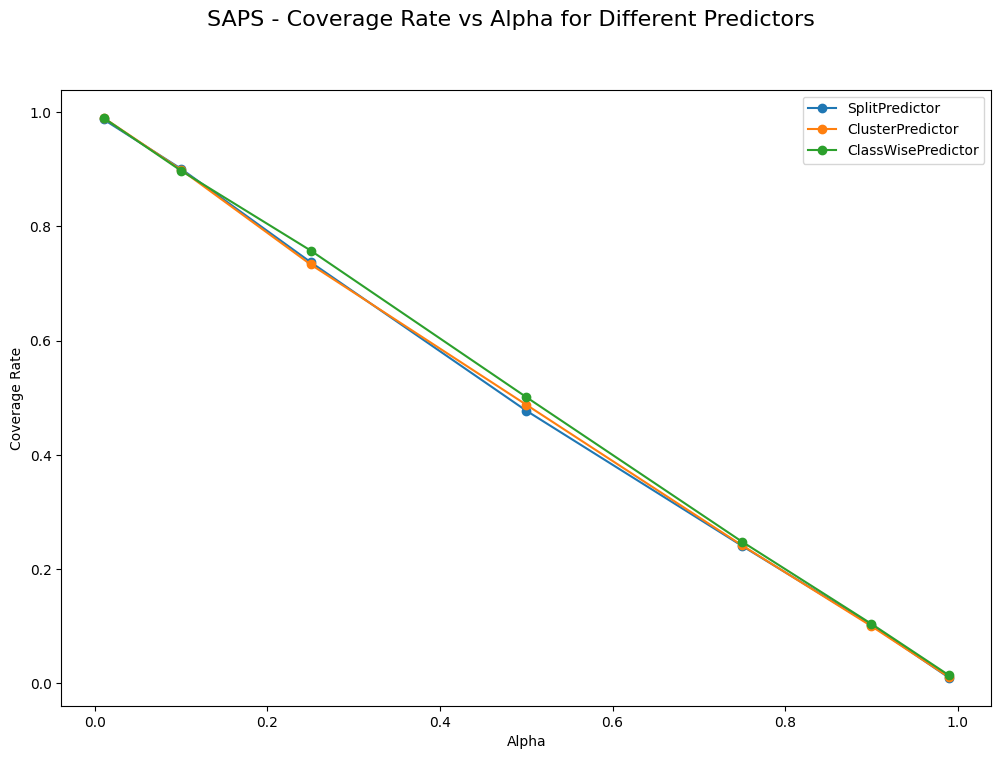

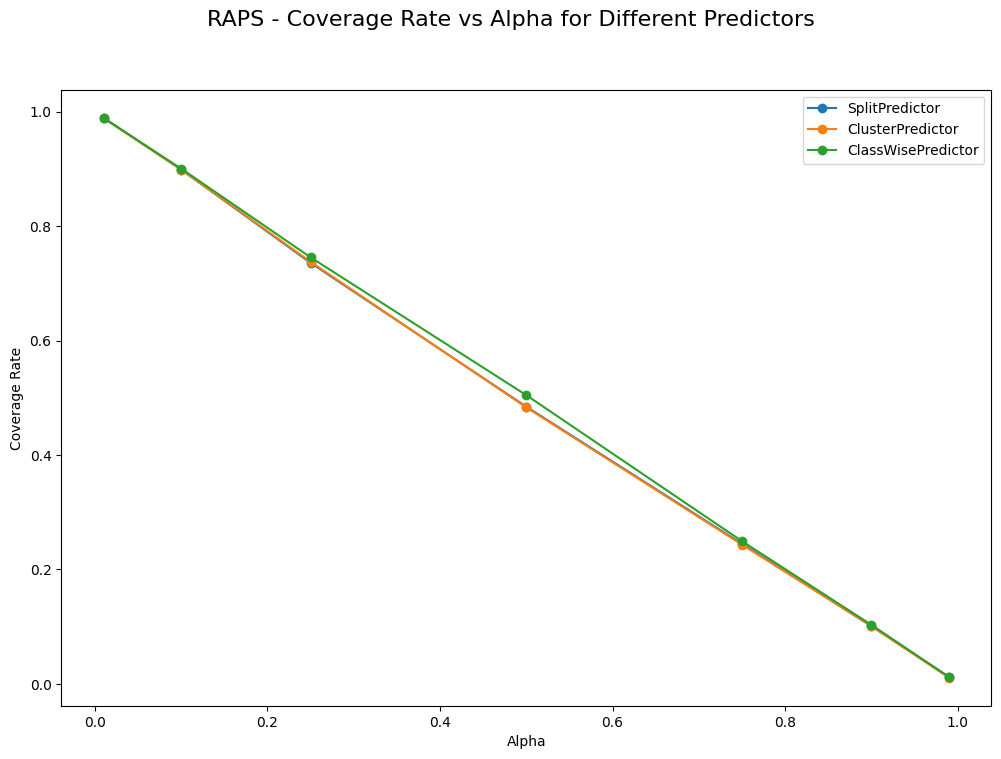

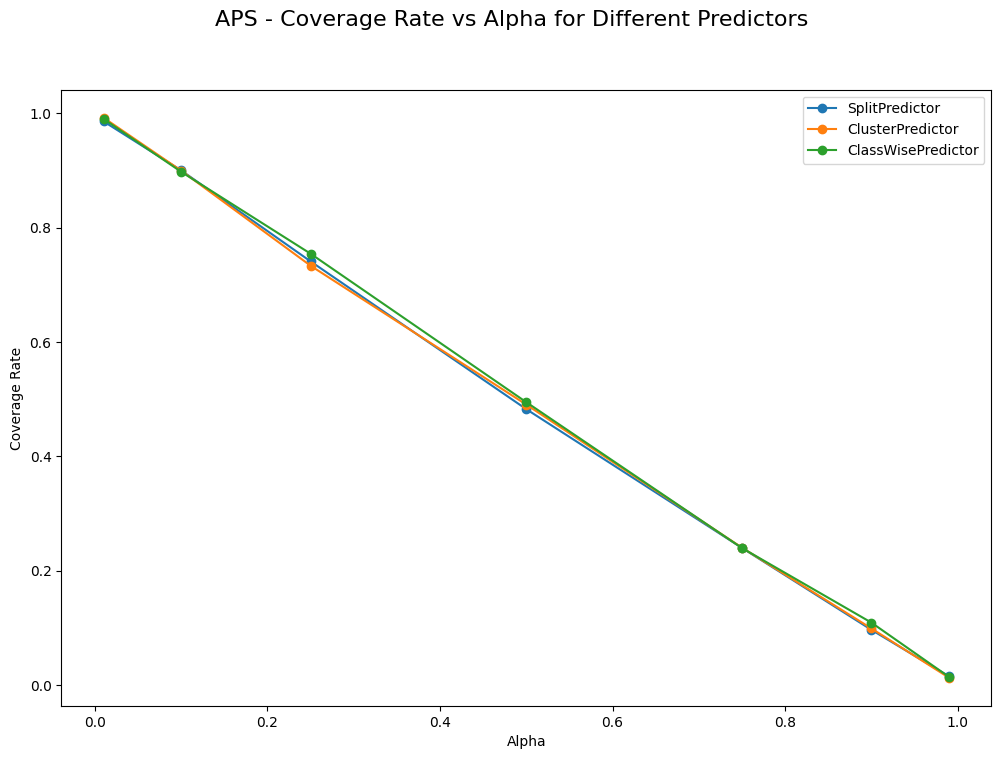

In [20]:
import os
predictors = ["SplitPredictor", "ClusterPredictor", "ClassWisePredictor"]

# Create a separate subplot for each predictor
for score_func, score_data in results_dict.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(f'{score_func} - Coverage Rate vs Alpha for Different Predictors', fontsize=16)

    # Loop over predictors for the current score function
    for predictor_name in predictors:
        # Get coverage rates for the current predictor and score function
        coverage_rates_mean = [np.mean(score_data[predictor_name]['coverage_rates'][i]) for i in range(len(alphas))]
            
        # Plot the coverage rates for each predictor on the same subplot
        ax.plot(alphas, coverage_rates_mean, marker='o', label=f'{predictor_name}')

    # Set common labels and legend for the subplot
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Coverage Rate')
    ax.legend()
    
    # Define the filename for the current plot
    plot_filename = os.path.join('./image', f'{score_func}_coverage.png')

    # Save the plot as an image
    plt.savefig(plot_filename)

    # Display the plot for the current predictor
    plt.show()

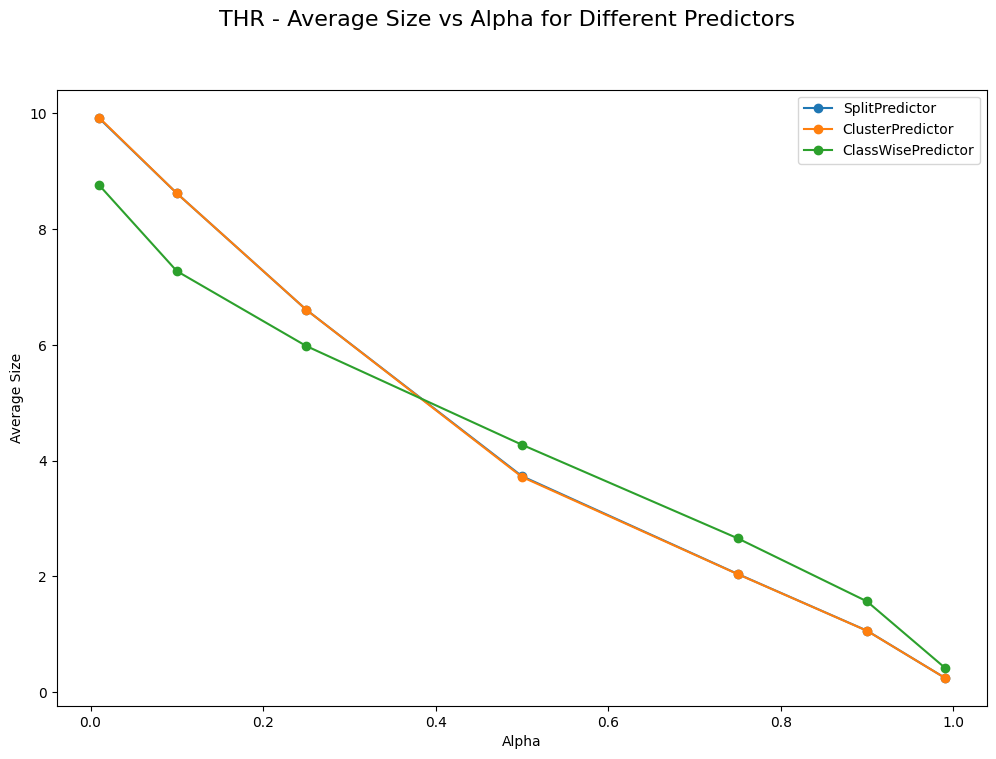

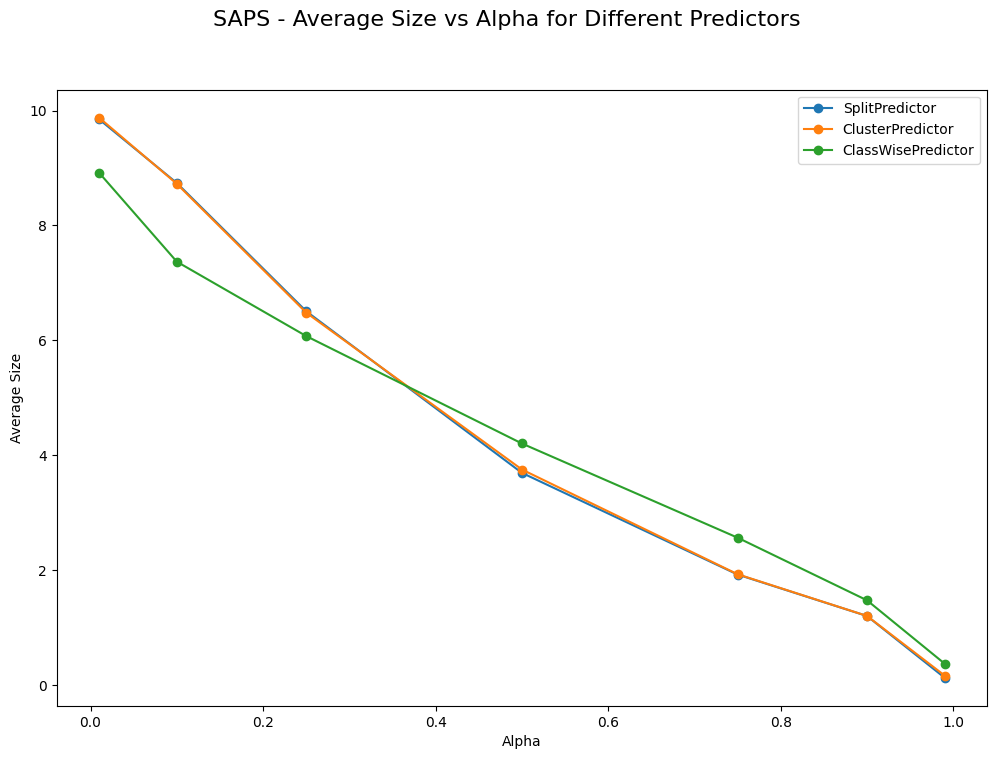

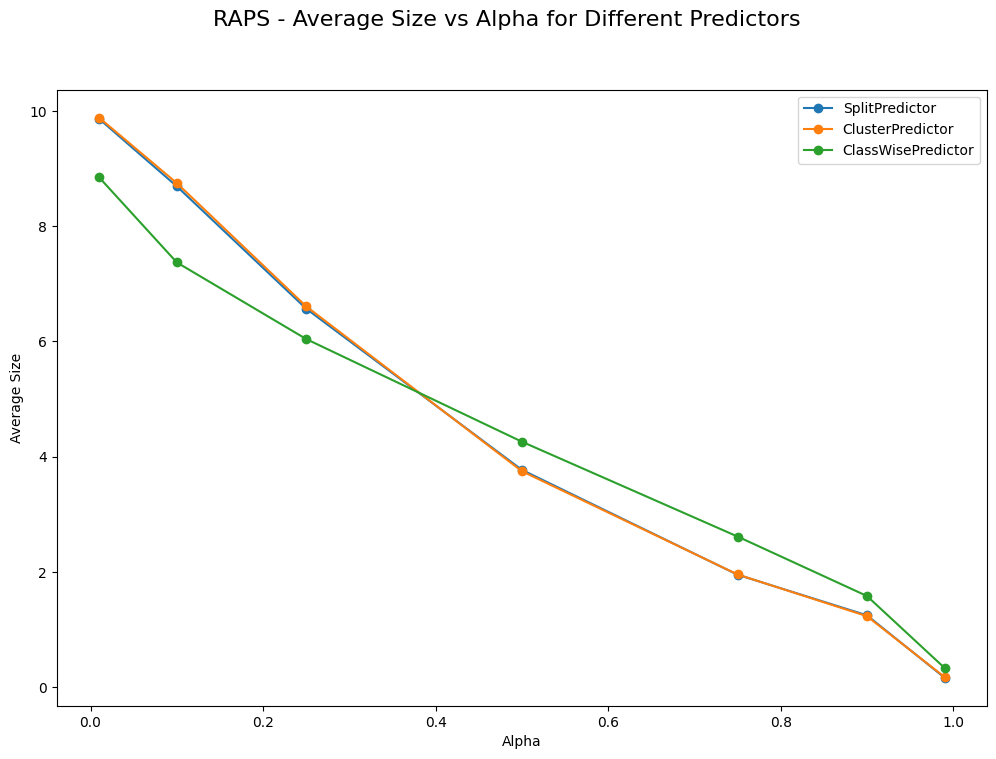

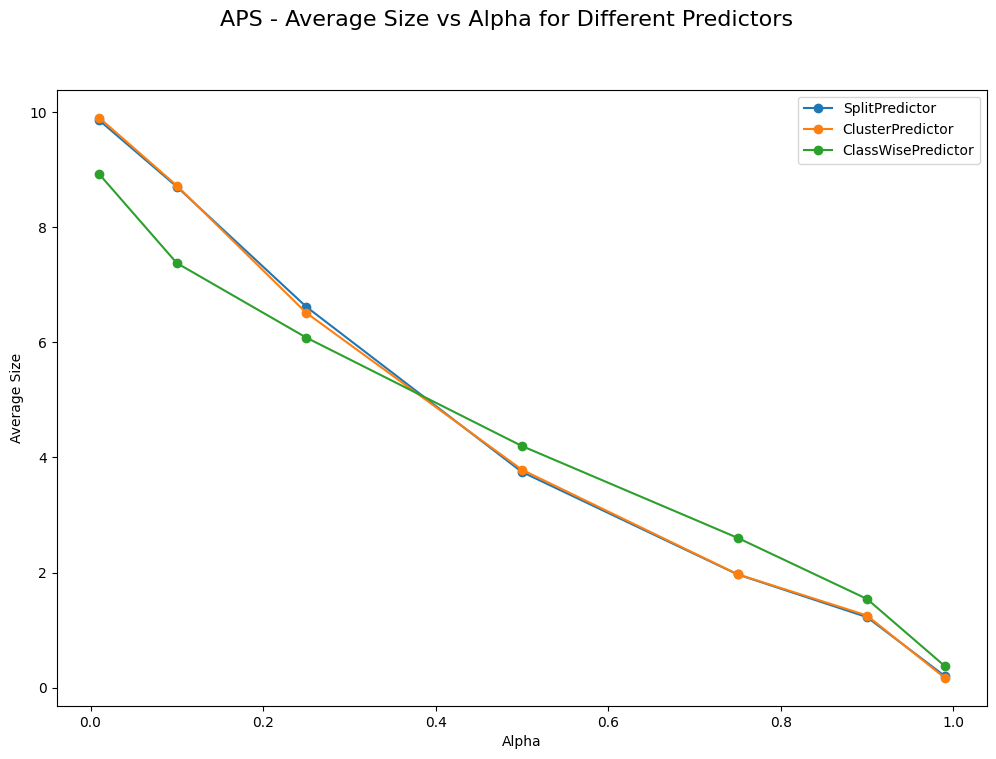

In [21]:
for score_func, score_data in results_dict.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(f'{score_func} - Average Size vs Alpha for Different Predictors', fontsize=16)

    # Loop over predictors for the current score function
    for predictor_name in predictors:
        # Get average sizes for the current predictor and score function
        average_sizes_mean = [np.mean(score_data[predictor_name]['average_sizes'][i]) for i in range(len(alphas))]
            
        # Plot the average sizes for each predictor on the same subplot
        ax.plot(alphas, average_sizes_mean, marker='o', label=f'{predictor_name}')

    # Set common labels and legend for the subplot
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Average Size')
    ax.legend()

    
    # Define the filename for the current plot
    plot_filename = os.path.join('./image', f'{score_func}_avgSize.png')

    # Save the plot as an image
    plt.savefig(plot_filename)

    # Display the plot for the current predictor
    plt.show()

In [17]:
import numpy as np

mean_coverage_rates = {}
mean_average_sizes = {}

for score_func in results_dict.keys():
    mean_coverage_rates[score_func] = {}
    mean_average_sizes[score_func] = {}
    
    for predictor_name in results_dict[score_func].keys():
        coverage_rates = results_dict[score_func][predictor_name]['coverage_rates']
        average_sizes = results_dict[score_func][predictor_name]['average_sizes']
        
        mean_coverage = np.mean(coverage_rates)
        mean_size = np.mean(average_sizes)
        
        mean_coverage_rates[score_func][predictor_name] = mean_coverage
        mean_average_sizes[score_func][predictor_name] = mean_size


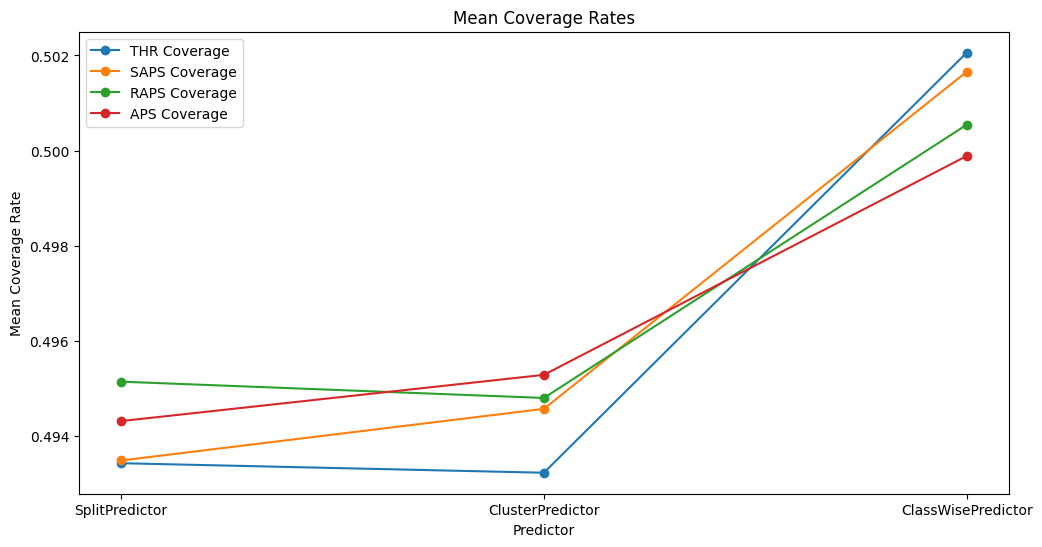

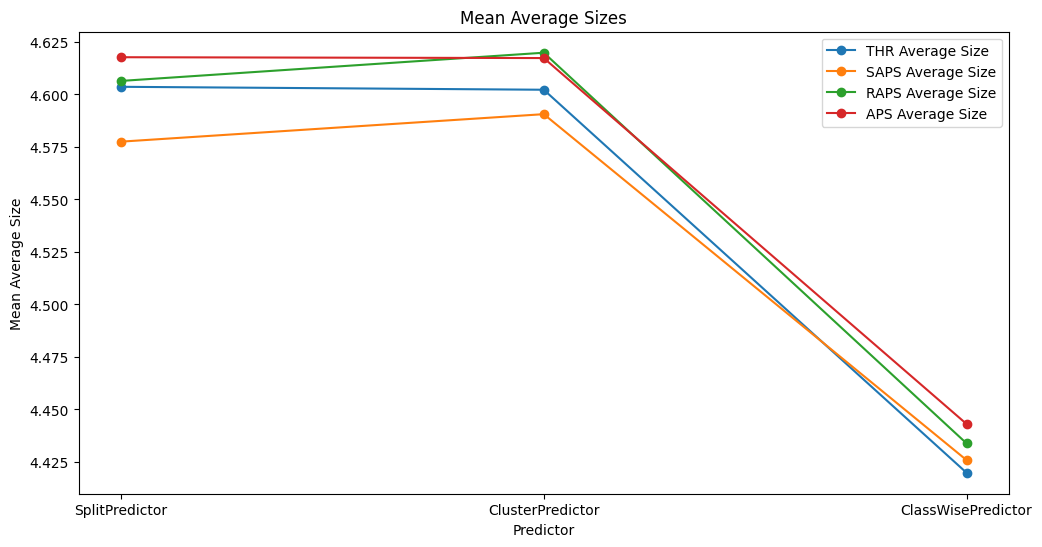

In [18]:
import matplotlib.pyplot as plt

# 创建图表1：覆盖率
plt.figure(figsize=(12, 6))

# 循环遍历每个得分函数
for score_func in mean_coverage_rates.keys():
    predictor_names = list(mean_coverage_rates[score_func].keys())
    
    # 绘制覆盖率的均值线
    coverage_means = [mean_coverage_rates[score_func][predictor_name] for predictor_name in predictor_names]
    plt.plot(predictor_names, coverage_means, label=f'{score_func} Coverage', marker='o')

# 添加图例、标题和轴标签
plt.legend()
plt.title('Mean Coverage Rates')
plt.xlabel('Predictor')
plt.ylabel('Mean Coverage Rate')

# Define the filename for the current plot
plot_filename = os.path.join('./image', f'Mean_Coverage.png')

# Save the plot as an image
plt.savefig(plot_filename)

# 显示图表
plt.show()

# 创建图表2：平均大小
plt.figure(figsize=(12, 6))

# 循环遍历每个得分函数
for score_func in mean_average_sizes.keys():
    predictor_names = list(mean_average_sizes[score_func].keys())
    
    # 绘制平均大小的均值线
    size_means = [mean_average_sizes[score_func][predictor_name] for predictor_name in predictor_names]
    plt.plot(predictor_names, size_means, label=f'{score_func} Average Size', marker='o')

# 添加图例、标题和轴标签
plt.legend()
plt.title('Mean Average Sizes')
plt.xlabel('Predictor')
plt.ylabel('Mean Average Size')

# Define the filename for the current plot
plot_filename = os.path.join('./image', f'Mean_avgSize.png')

# Save the plot as an image
plt.savefig(plot_filename)

# 显示图表
plt.show()


In [3]:
# results_dict =  {'THR': {'SplitPredictor': {'coverage_rates': [0.0078, 0.093, 0.2452, 0.4886, 0.7456, 0.8996, 0.9884], 
#                                             'average_sizes': [0.1532, 1.153, 3.1124, 5.6142, 7.7836, 9.1218, 9.861]}, 
#                          'ClusterPredictor': {'coverage_rates': [0.0084, 0.093, 0.2428, 0.4902, 0.744, 0.8986, 0.9884], 
#                                               'average_sizes': [0.1606, 1.153, 3.079, 5.6338, 7.7668, 9.1168, 9.8614]}, 
#                          'ClassWisePredictor': {'coverage_rates': [0.0128, 0.0998, 0.2468, 0.4892, 0.735, 0.889, 0.9906], 
#                                                 'average_sizes': [0.5352, 2.1468, 3.737, 5.8072, 7.7134, 8.8648, 9.7352]}}, 
#                  'SAPS': {'SplitPredictor': {'coverage_rates': [0.0092, 0.0958, 0.2388, 0.4832, 0.744, 0.8976, 0.9926], 
#                                              'average_sizes': [0.131, 1.2502, 2.937, 5.5562, 7.7324, 8.92, 9.9124]}, 
#                           'ClusterPredictor': {'coverage_rates': [0.0106, 0.093, 0.2404, 0.4958, 0.7478, 0.9, 0.987], 
#                                                'average_sizes': [0.124, 1.235, 2.9572, 5.642, 7.758, 8.9442, 9.8746]}, 
#                           'ClassWisePredictor': {'coverage_rates': [0.011, 0.0914, 0.2424, 0.4982, 0.744, 0.8932, 0.9874], 
#                                                  'average_sizes': [0.3768, 1.6818, 3.436, 5.7138, 7.6538, 8.8766, 9.8508]}}, 
#                  'RAPS': {'SplitPredictor': {'coverage_rates': [0.0082, 0.0952, 0.2402, 0.4864, 0.7488, 0.8956, 0.9894], 
#                                              'average_sizes': [0.1142, 1.2644, 2.9448, 5.5564, 7.7902, 8.9164, 9.8624]}, 
#                           'ClusterPredictor': {'coverage_rates': [0.0114, 0.0956, 0.2424, 0.4732, 0.7458, 0.899, 0.9902], 
#                                                'average_sizes': [0.1512, 1.2632, 2.9592, 5.4634, 7.7702, 8.9378, 9.8782]}, 
#                           'ClassWisePredictor': {'coverage_rates': [0.012, 0.0942, 0.2394, 0.4902, 0.7386, 0.8922, 0.9852], 
#                                                  'average_sizes': [0.3976, 1.787, 3.4048, 5.6604, 7.6154, 8.8522, 9.8032]}}, 
#                  'APS': {'SplitPredictor': {'coverage_rates': [0.0136, 0.096, 0.2418, 0.489, 0.748, 0.9, 0.993], 
#                                             'average_sizes': [0.1552, 1.2546, 2.9336, 5.5494, 7.7816, 8.9448, 9.9024]}, 
#                          'ClusterPredictor': {'coverage_rates': [0.0092, 0.0984, 0.2426, 0.488, 0.7518, 0.8968, 0.9888], 
#                                               'average_sizes': [0.1342, 1.2978, 2.9372, 5.5472, 7.8086, 8.9402, 9.8788]}, 
#                          'ClassWisePredictor': {'coverage_rates': [0.0132, 0.0936, 0.2416, 0.4878, 0.7438, 0.8956, 0.9882], 
#                                                 'average_sizes': [0.3968, 1.7656, 3.412, 5.6576, 7.6252, 8.8982, 9.8158]}}}

In [23]:
# 创建一个空字典来存储每个预测器的平均覆盖率
average_coverage_per_predictor = {}

# 遍历每个得分函数
for score_func, predictor_data in results_dict.items():
    for predictor, data in predictor_data.items():
        # 获取覆盖率数据
        coverage_rates = data['coverage_rates']
        
        # 计算覆盖率的平均值
        average_coverage = sum(coverage_rates) / len(coverage_rates)
        
        # 如果预测器不在字典中，添加它
        if predictor not in average_coverage_per_predictor:
            average_coverage_per_predictor[predictor] = {}
        
        # 将得分函数和平均覆盖率添加到字典中
        average_coverage_per_predictor[predictor][score_func] = average_coverage

# 打印每个预测器的平均覆盖率
for predictor, score_func_data in average_coverage_per_predictor.items():
    print(f'Predictor: {predictor}')
    for score_func, average_coverage in score_func_data.items():
        print(f'{score_func}: {average_coverage}')


Predictor: SplitPredictor
THR: 0.4934285714285714
SAPS: 0.4934857142857143
RAPS: 0.4951428571428571
APS: 0.49431428571428576
Predictor: ClusterPredictor
THR: 0.49322857142857146
SAPS: 0.49457142857142855
RAPS: 0.4948
APS: 0.4952857142857143
Predictor: ClassWisePredictor
THR: 0.5020571428571429
SAPS: 0.5016571428571428
RAPS: 0.5005428571428572
APS: 0.4998857142857143
